*A Neural Network using pytorch and it's torch.nn module*

# Imports

As usual, first we import everything we will require to build our neural network.

In [ ]:
import torch
import torchvision
import torch.nn as nn # All neural network modules, nn.Linear, nn.Conv2d, BatchNorm, Loss functions
import torch.optim as optim # For all Optimization algorithms, SGD, Adam, etc.
import torch.nn.functional as F # All functions that don't have any parameters
from torch.utils.data import DataLoader # Gives easier dataset managment and creates mini batches
import torchvision.datasets as datasets # Has standard datasets we can import easily
import torchvision.transforms as transforms # Transformations we can perform on our dataset
import matplotlib.pyplot as plt # will be used to plot images from MNIST


# Loading Data

Here we load the training and testing dataset. We also prepare the dataloaders that will iterate through the data in batches during our training phase

In [ ]:
batch_size = 64 #how many samples our model sees at once/ pass through the model at once

train_dataset = datasets.MNIST(
    root="dataset/",
    train=True,   # Since we will be using this for training
    transform=transforms.ToTensor(),
    download=True,
)
train_loader = DataLoader(
    dataset=train_dataset, batch_size=batch_size, shuffle=True
)
test_dataset = datasets.MNIST(
    root="dataset/",
    train=False,
    transform=transforms.ToTensor(),
    download=True,
)
test_loader = DataLoader(
    dataset=test_dataset, batch_size=batch_size, shuffle=True
)

100%|██████████| 9912422/9912422 [00:00<00:00, 102740044.94it/s]


Extracting dataset/MNIST/raw/train-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 30367433.90it/s]


Extracting dataset/MNIST/raw/train-labels-idx1-ubyte.gz to dataset/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 26622416.14it/s]


Extracting dataset/MNIST/raw/t10k-images-idx3-ubyte.gz to dataset/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3016710.81it/s]

Extracting dataset/MNIST/raw/t10k-labels-idx1-ubyte.gz to dataset/MNIST/raw



# Understanding the dataset

Over the next few cells we will try and understand what our dataset looks like and the kind of model we need to build

In [ ]:
print(len(train_dataset))
print(len(test_dataset))

60000
10000


In [ ]:
print(train_dataset[0])

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

In [ ]:
print(train_dataset[0][0].shape)

torch.Size([1, 28, 28])


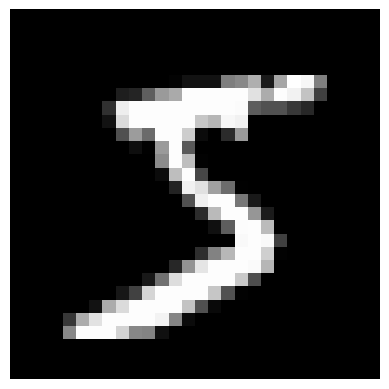

In [ ]:
plt.imshow(train_dataset[0][0].squeeze().numpy(), cmap='gray')
plt.axis('off')
plt.show()

# Building the Model

Here we will be initialising the hyperparameters, selecting the loss function & optimiser and building the architecture of the neural network

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = 784 # 28x28 = 784, size of MNIST images (grayscale), we will compress the inputs from train_dataset during iterating later
num_classes = 10
learning_rate = 0.001
num_epochs = 3

In [ ]:
class NN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(NN, self).__init__()
        self.fc1 = nn.Linear(input_size, 50)
        self.fc2 = nn.Linear(50, num_classes)
        # nn. Linear(n,m) is a module that creates single layer feed forward network with n inputs and m output.
        # Mathematically, this module is designed to calculate the linear equation Ax = b where x is input, b is output, A is weight.

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
class NN(nn.Sequential):  # alternative to using nn.module when just building a linear neural network
    def __init__(self, input_size, num_classes):
        super().__init__(
           nn.Linear(input_size, 50),
           nn.ReLU(),
           nn.Linear(50, num_classes),
           )

In [ ]:
model = NN(input_size=input_size, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for batch_idx, (data, targets) in enumerate(train_loader):

  if batch_idx>935: # only printing the last 2 iterations
    data = data.to(device=device) # Get data to cuda if possible and ensure all our computation is on the same device
    targets = targets.to(device=device)

    # Get to correct shape
    # -1 will flatten all outer dimensions into one
    data = data.reshape(data.shape[0], -1)  # data is originially of the shape 1,28,28
                                            # sice we are passing 64 samples of shape 1,28,28 at once through the model
                                            # thus the reshaped tensor is of shape 1,(28*28)= 1,784

    print(data.shape) # confirming our data is properly reshaped

    print(targets)
    print(targets.shape)

    scores = model(data)  # making our predictions i.e. running the data through the model

    print(scores)
    print(scores.shape) # checking that we have the right shape.. which is?

    loss = criterion(scores, targets) # calculating the loss
    print(loss)
  else:
    continue

tensor([9, 1, 4, 0, 3, 2, 9, 1, 6, 5, 3, 7, 8, 0, 7, 3, 2, 7, 7, 1, 6, 8, 7, 3,
        9, 4, 4, 1, 7, 1, 0, 1, 6, 4, 0, 3, 3, 7, 0, 6, 1, 8, 7, 6, 2, 3, 1, 5,
        9, 0, 2, 9, 1, 9, 5, 5, 7, 8, 2, 9, 1, 0, 7, 7])
tensor([[ 9.8769e-02, -5.3561e-02, -2.0750e-02, -1.3181e-01, -1.0053e-01,
          6.0082e-03, -1.3565e-01,  1.6104e-01,  1.1245e-01, -1.2824e-02],
        [ 3.9910e-02, -1.2318e-02, -1.4538e-02, -1.6280e-01, -1.8012e-01,
          7.1712e-02, -4.4927e-02,  9.5309e-02,  9.0295e-02, -2.4906e-02],
        [ 4.0028e-02, -1.5994e-01, -5.8433e-02, -1.2640e-01, -7.4184e-02,
          4.7739e-02, -1.3751e-01,  1.8580e-01,  1.5276e-01, -2.5543e-02],
        [-5.6897e-02,  6.5495e-02, -1.7964e-01, -7.5689e-02, -9.4032e-02,
          1.2958e-01, -1.0266e-01,  1.3185e-01,  1.3364e-01, -1.3666e-02],
        [ 3.0614e-02, -3.6379e-02, -2.9704e-02, -8.0381e-02, -1.5200e-01,
          4.3632e-02, -1.3486e-01,  1.2182e-01,  1.5284e-01,  9.2177e-02],
        [ 1.7199e-01, -3.0306e-02, -3.

# Training the Model

In [ ]:
for epoch in range(num_epochs):
    print(f"Epoch: {epoch}")
    for batch_idx, (data, targets) in enumerate(train_loader):
        # Get data to cuda if possible
        data = data.to(device=device)
        targets = targets.to(device=device)

        # Get to correct shape, 28x28->784
        # -1 will flatten all outer dimensions into one
        data = data.reshape(data.shape[0], -1)

        # forward propagation
        scores = model(data)
        loss = criterion(scores, targets)

        # zero previous gradients
        optimizer.zero_grad()

        # back-propagation
        loss.backward()

        # gradient descent or in this case: adam step
        optimizer.step()

Epoch: 0
Epoch: 1
Epoch: 2


# Checking accuracy

In [ ]:
def check_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()  # puts the model in evaluation mode

    with torch.no_grad():
        for x, y in loader: # here x and y are your input image as a tensor and targets
            x = x.to(device=device)
            y = y.to(device=device)
            x = x.reshape(x.shape[0], -1) # reshaping data before putting it into our model, as we did earlier

            scores = model(x)
            _, predictions = scores.max(1)  # your model is essentially predicting whichever values of the 10 classes is maximum
            num_correct += (predictions == y).sum()
            num_samples += predictions.size(0)

        print(
            f"Got {num_correct} / {num_samples} with accuracy"
            f" {float(num_correct) / float(num_samples) * 100:.2f}"
        )

    model.train() # this is strictly speaking not necessary since we are not training the model after this,
                  # but if we checked accuracy mid training it is needed

In [ ]:
check_accuracy(train_loader, model)
check_accuracy(test_loader, model)

Got 57595 / 60000 with accuracy 95.99
Got 9547 / 10000 with accuracy 95.47
